### Chapter 4 Homework Solutions    

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

### Chapter 4 Homework - Lecture 1

In [2]:
def target_density(x):
    """
    target density for the Metropolis algorithm

    in this example, the target distribution is a standard normal distribution:
        p(x) =~ exp(-0.5 * x^2)

    Parameters
    ----------
    x : float or ndarray
        point(s) at which to evaluate the unnormalized density

    Returns
    -------
    float or ndarray
        value(s) of the unnormalized density at x
    """
    return np.exp(-0.5 * x**2)


def metropolis_step(p, x, proposal_std):
    """
    perform one Metropolis step for a single Markov chain

    steps:
        - generate a proposal state by adding Gaussian noise to the current state
        - compute the acceptance probability alpha = min(1, p(x_proposed)/p(x_current))
        - draw u ~ Uniform(0,1); then accept the proposal if u < alpha; otherwise, keep current state

    Parameters
    ----------
    p : callable
        function proportional to the target density p(x)
    x : float
        current state of the Markov chain
    proposal_std : float
        standard deviation of the Gaussian proposal distribution

    Returns
    -------
    x_new : float
        next state of the Markov chain after this Metropolis step
    """
    # propose a new state using Gaussian random walk
    x_hat = x + np.random.randn() * proposal_std

    # compute acceptance probability
    alpha = min(1, p(x_hat) / p(x))

    # accept or reject the proposal
    u = np.random.uniform(0, 1)  
    if u < alpha:
        x = x_hat # accept

    return x


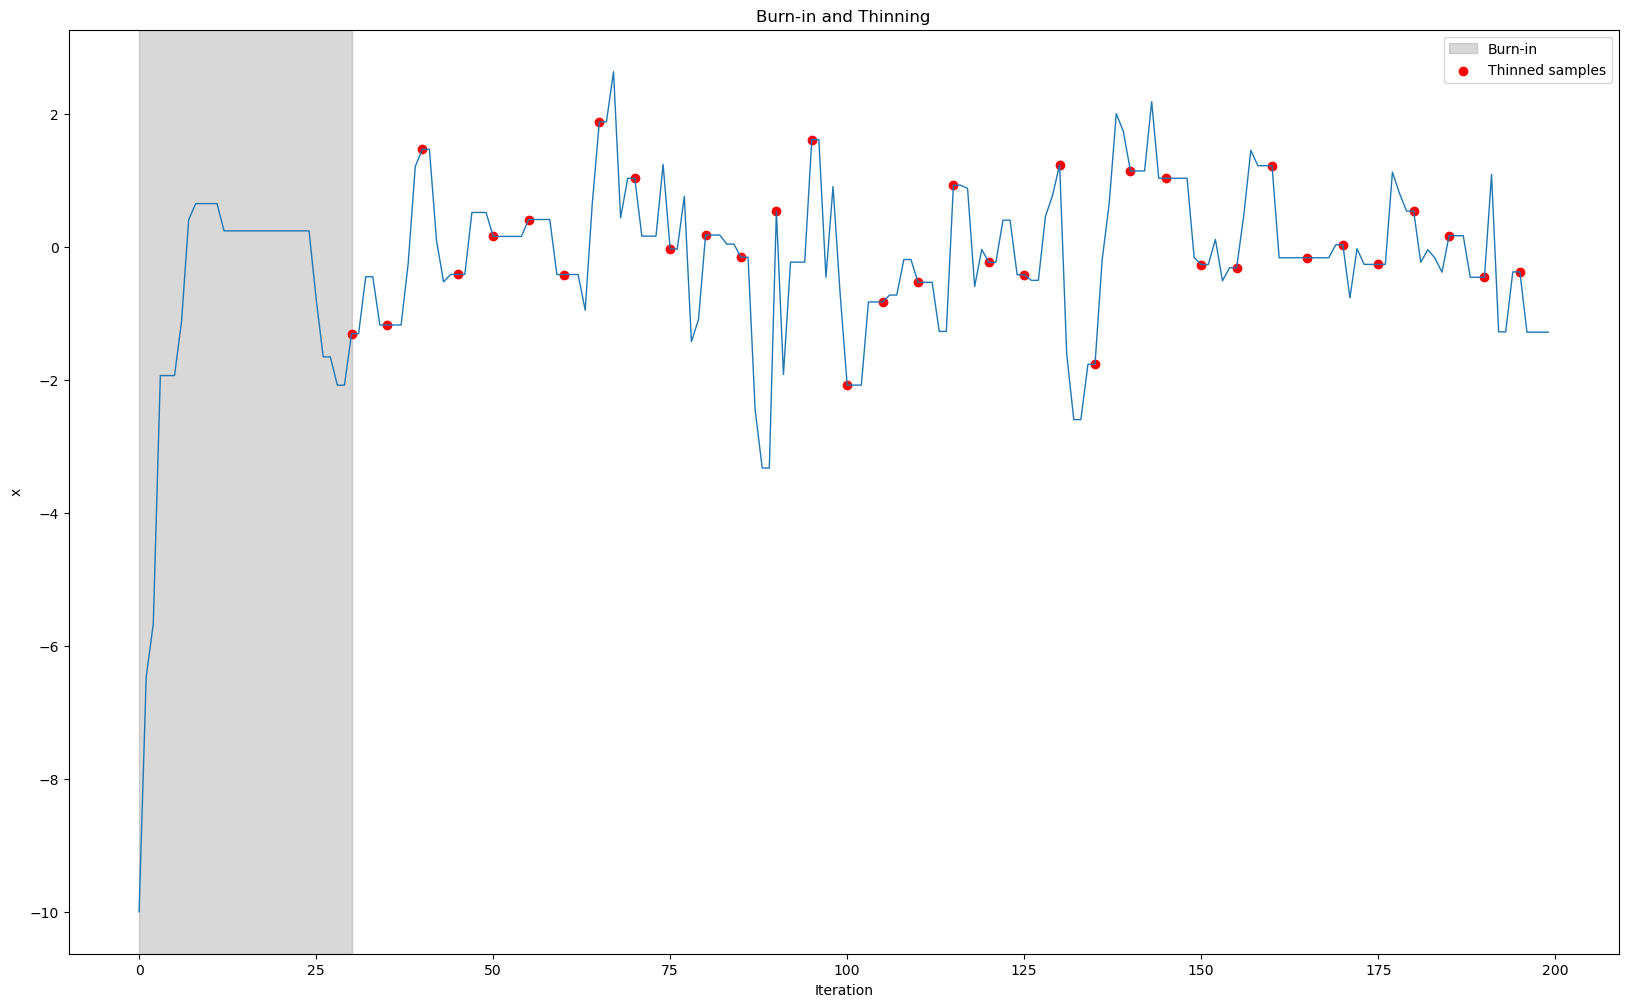

In [3]:
# initialize a single chain
np.random.seed(0)
n_steps = 200
proposal_std = 2
x = np.zeros(n_steps)
x[0] = -10

# simulate a single chain
for t in range(1, n_steps):
    x[t] = metropolis_step(target_density, x[t-1], proposal_std)

# plot
plt.figure(figsize=(20, 12))
plt.plot(x, lw=1)
plt.axvspan(0, 30, color='gray', alpha=0.3, label='Burn-in')
plt.scatter(np.arange(30, n_steps, 5), x[30::5], color='red', label='Thinned samples')
plt.xlabel('Iteration')
plt.ylabel('x')
plt.title('Burn-in and Thinning')
plt.legend()
plt.show()

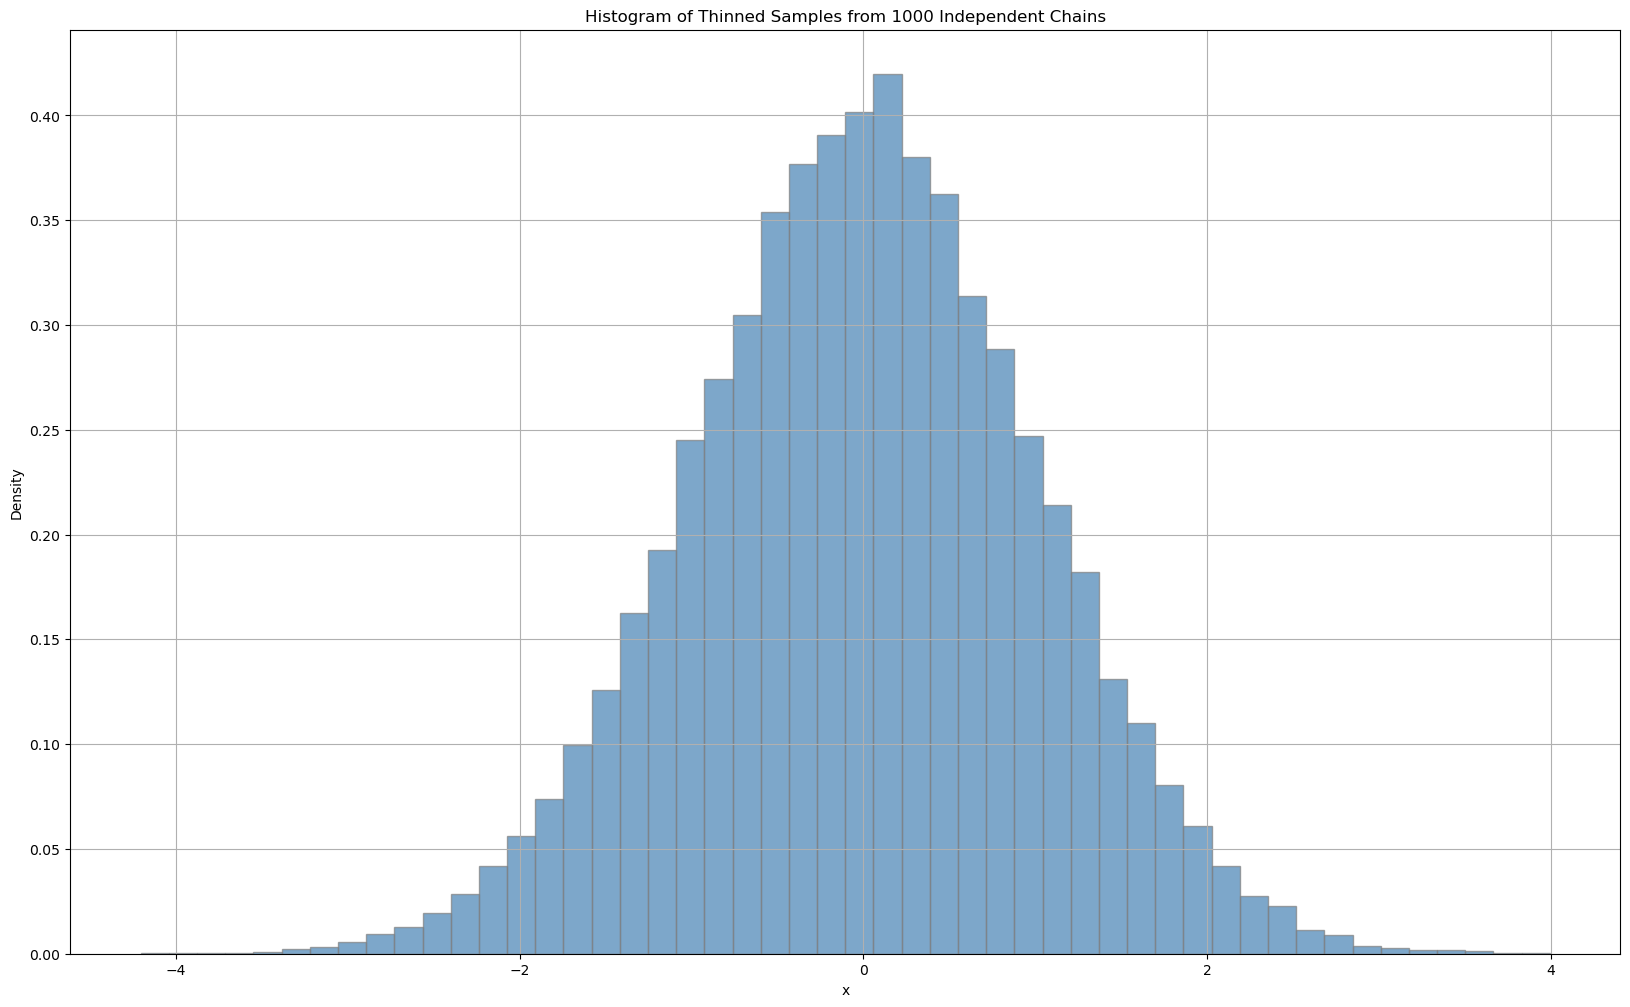

In [4]:
# simulation parameters
n_chains = 1000       # number of independent chains
burn_in = 30
thin = 5
chains = np.random.uniform(-10, 10, size=n_chains)

# run chains and collect thinned samples
thinned_samples = []
for t in range(n_steps):
    for i in range(n_chains):
        chains[i] = metropolis_step(target_density, chains[i], proposal_std)
    # after burn-in, collect thinned samples
    if t >= burn_in and (t - burn_in) % thin == 0:
        thinned_samples.extend(chains.copy())

thinned_samples = np.array(thinned_samples)

# plot histogram of thinned samples
plt.figure(figsize=(20, 12))
plt.hist(thinned_samples, bins=50, density=True, color='steelblue', edgecolor='gray', alpha=0.7)
plt.xlabel('x')
plt.ylabel('Density')
plt.title(f'Histogram of Thinned Samples from {n_chains} Independent Chains')
plt.grid(True)
plt.show()


### Comment on the Histogram

After running many independent chains, applying burn-in and thinning, the combined thinned samples form a histogram that approximates the target distribution.

The histogram shows the probability density of the target, with higher frequencies where the distribution has higher probability (near the mean, lower spread in the tails).

As the number of chains and samples increases, the histogram converges to the true Normal(0,10) density.

This demonstrates the key property of MCMC: even though individual samples are dependent and start from different points, after burn-in and with sufficient sampling, the collected samples are effectively drawn from the stationary distribution.


### Chapter 4 Homework - Lecture 2

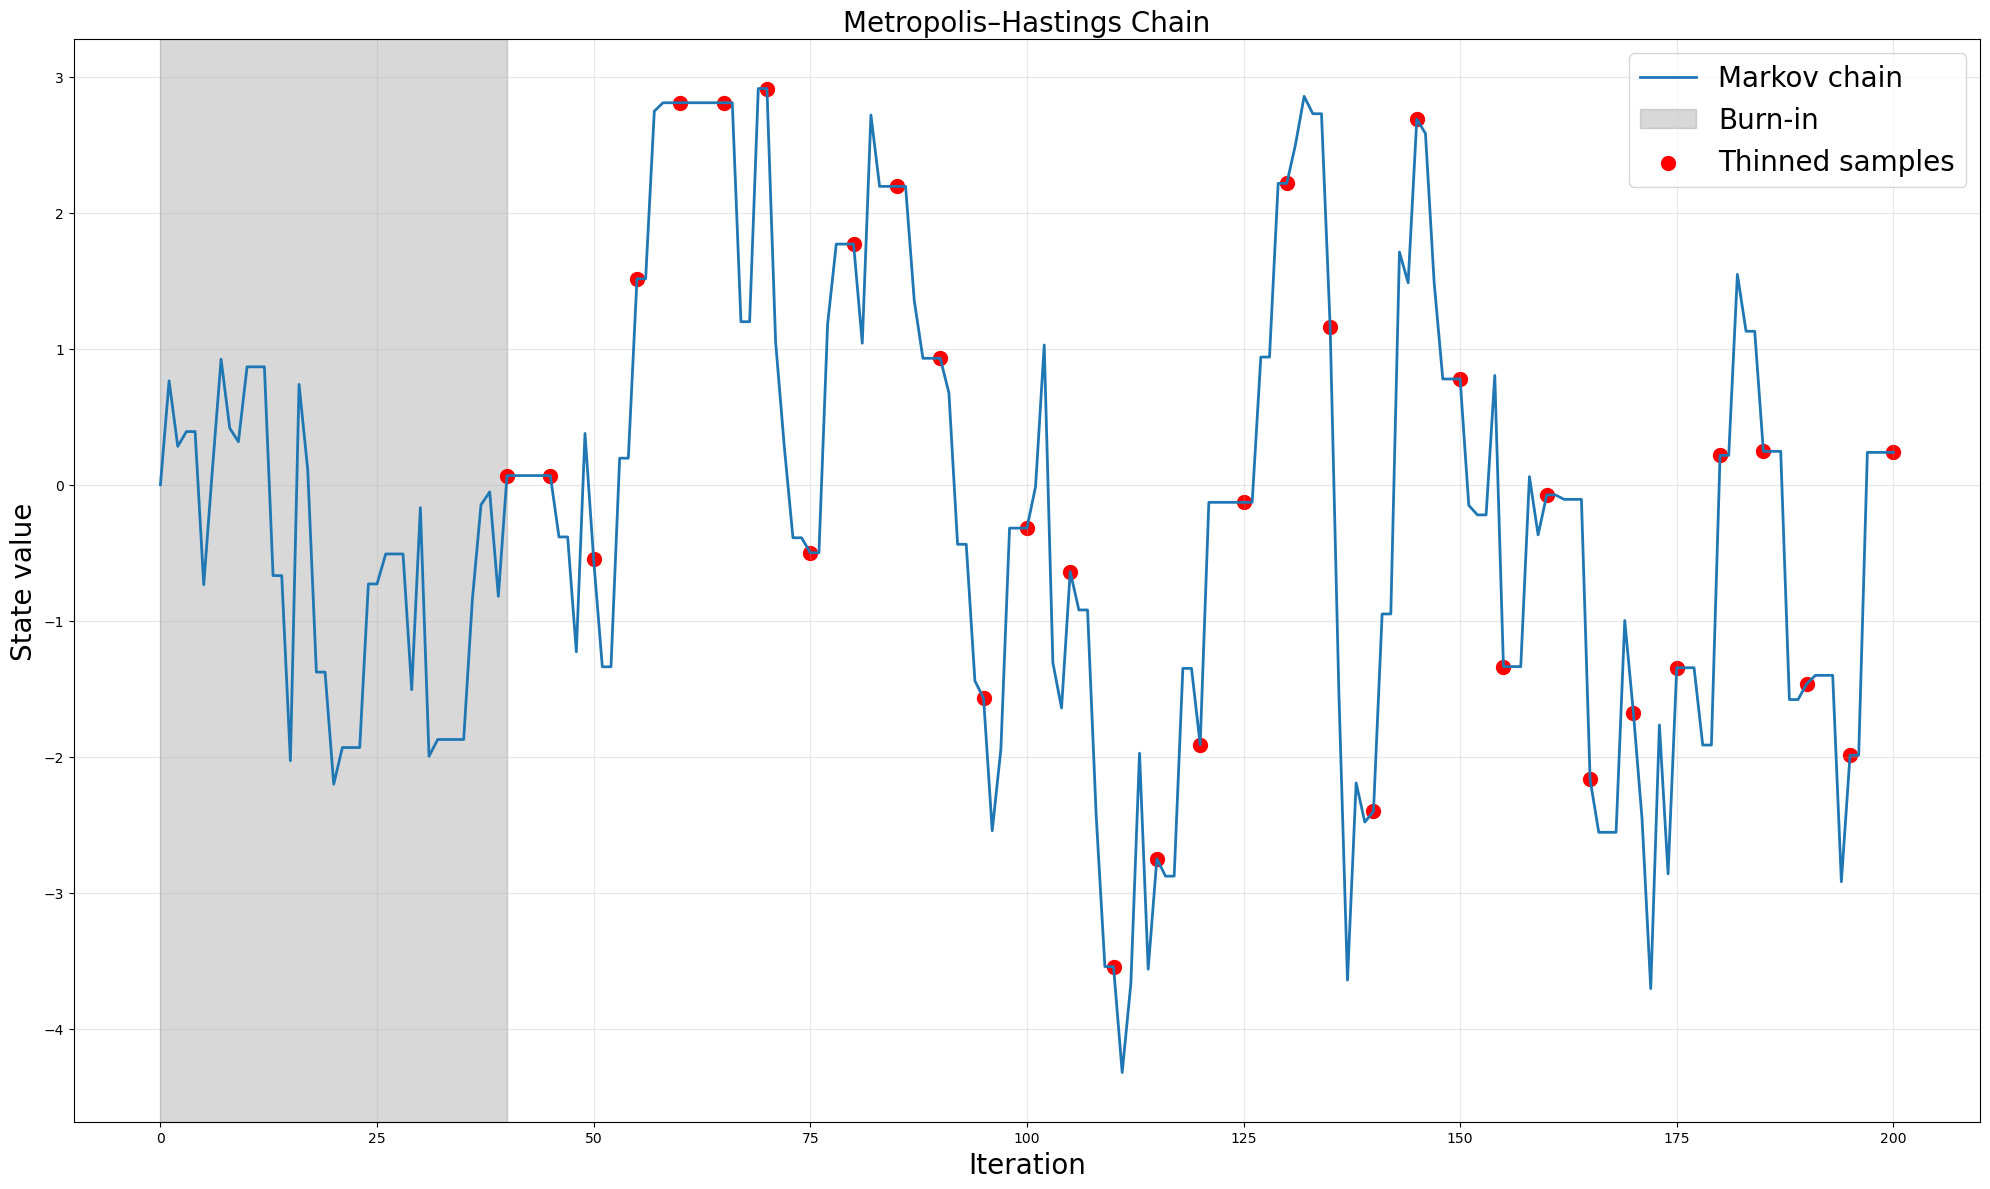

In [ ]:
def target(x):
    """
    Normal(0, 4) ∝ exp(-x^2 / 8)
    
    Returns:
        float: value of the unnormalized density at x
    """
    return np.exp(-x**2 / 8)
    
def proposal_fn(x, step_size=1.0):
    """
    asymmetric proposal mechanism for Metropolis Hastings
    
    with probability 0.7 propose from Normal(x + step_size, 1)
    with probability 0.3 propose from Normal(x - step_size, 1)
    
    Parameters
    ----------
        x (float): current state of the Markov chain
        step_size (float): magnitude of the directional shift
    
    Returns
    -------
        float: a proposed new state
    """
    if np.random.rand() < 0.7:
        return np.random.normal(x + step_size, 1)
    else:
        return np.random.normal(x - step_size, 1)


def proposal_density_fn(x_new, x_old, step_size=1.0):
    """
    this function is required for evaluating 
        q(x_old | x_new) / q(x_new | x_old)
    in the MH acceptance probability
    
    Parameters
    -------
        x_new (float) is the roposed state
        x_old (float) is the current state.
        step_size (float) is directional shift in the proposal centers
    
    Returns
    -------
        float: the proposal density q(x_new | x_old)
    """
    return (
        0.7 * norm.pdf(x_new, loc=x_old + step_size, scale=0.5) +
        0.3 * norm.pdf(x_new, loc=x_old - step_size, scale=0.5)
    )


def metropolis_hastings(target, T=5000, x0=0.0,
                        proposal_fn=None, proposal_density_fn=None,
                        step_size=0.8):
    """
    Metropolis Hastings algorithm

    This function simulates a Markov chain whose stationary distribution
    is the target distribution p(x). It supports both symmetric and
    asymmetric proposal distributions.

    Parameters
    ----------
    target : callable
        Unnormalized target density function p(x). 
        This function does not need to integrate to 1.
    
    T : int
        number of MH iterations to run

    x0 : float
        initial state of the Markov chain

    proposal_fn : callable
        function generating a proposed state x_prop ~ q(x_prop | x_old).

    proposal_density_fn : callable or None
        Function that evaluates the proposal density q(x_new | x_old).  
        If provided the algorithm computes the full MH acceptance ratio:
            alpha = min(1, p(x_prop)/p(x_old) * q(x_old|x_prop)/q(x_prop|x_old))
        
        If None the proposal is assumed to be symmetric and the ratio
            q(x_old | x_prop) / q(x_prop | x_old) 
        is omitted.

    step_size : float
        parameter passed to the proposal function to control proposal scale

    Returns
    -------
    np.ndarray
        array of length T+1 containing the Markov chain states
    """
    
    # initialize chain storage
    x = np.zeros(T + 1)
    x[0] = x0

    for t in range(1, T + 1):

        # propose a new candidate 
        x_prop = proposal_fn(x[t - 1], step_size)

        # compute acceptance ratio 
        numerator = target(x_prop)
        denominator = target(x[t - 1])

        # if asymmetric proposal include ratio
        if proposal_density_fn is not None:
            numerator *= proposal_density_fn(x[t - 1], x_prop, step_size)
            denominator *= proposal_density_fn(x_prop, x[t - 1], step_size)

        alpha = min(1, numerator / denominator)

        # acceptence conditions
        if np.random.rand() < alpha:
            x[t] = x_prop  
        else:
            x[t] = x[t - 1]

    return x


# MCMC settings
T = 200          #total number of MH iterations
burn_in = 40     #number of initial samples to discard
thinning = 5     #retain every 4th post–burn-in sample

# run a single Metropolis–Hastings chain
x_single = metropolis_hastings(target=target,T=T, x0=0, proposal_fn=proposal_fn, proposal_density_fn=proposal_density_fn, step_size=1.0)

# burn-in and thinning
# remove the burn-in portion of the chain
post_burnin = x_single[burn_in:]
# indices of retained samples after thinning
thin_idx = np.arange(0, len(post_burnin), thinning)

# take the thinned samples and corresponding iteration numbers
thinned_samples = post_burnin[thin_idx]
thinned_iters = thin_idx + burn_in     

# plot
plt.figure(figsize=(20, 12))
plt.plot(x_single, lw=2, label="Markov chain")
plt.axvspan(0, burn_in, color='gray', alpha=0.3, label='Burn-in')
plt.scatter(thinned_iters, thinned_samples, color='red', label='Thinned samples', s=100)
plt.title("Metropolis–Hastings Chain", fontsize=20)
plt.xlabel("Iteration", fontsize=20)
plt.ylabel("State value", fontsize=20)
plt.legend(fontsize=20)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

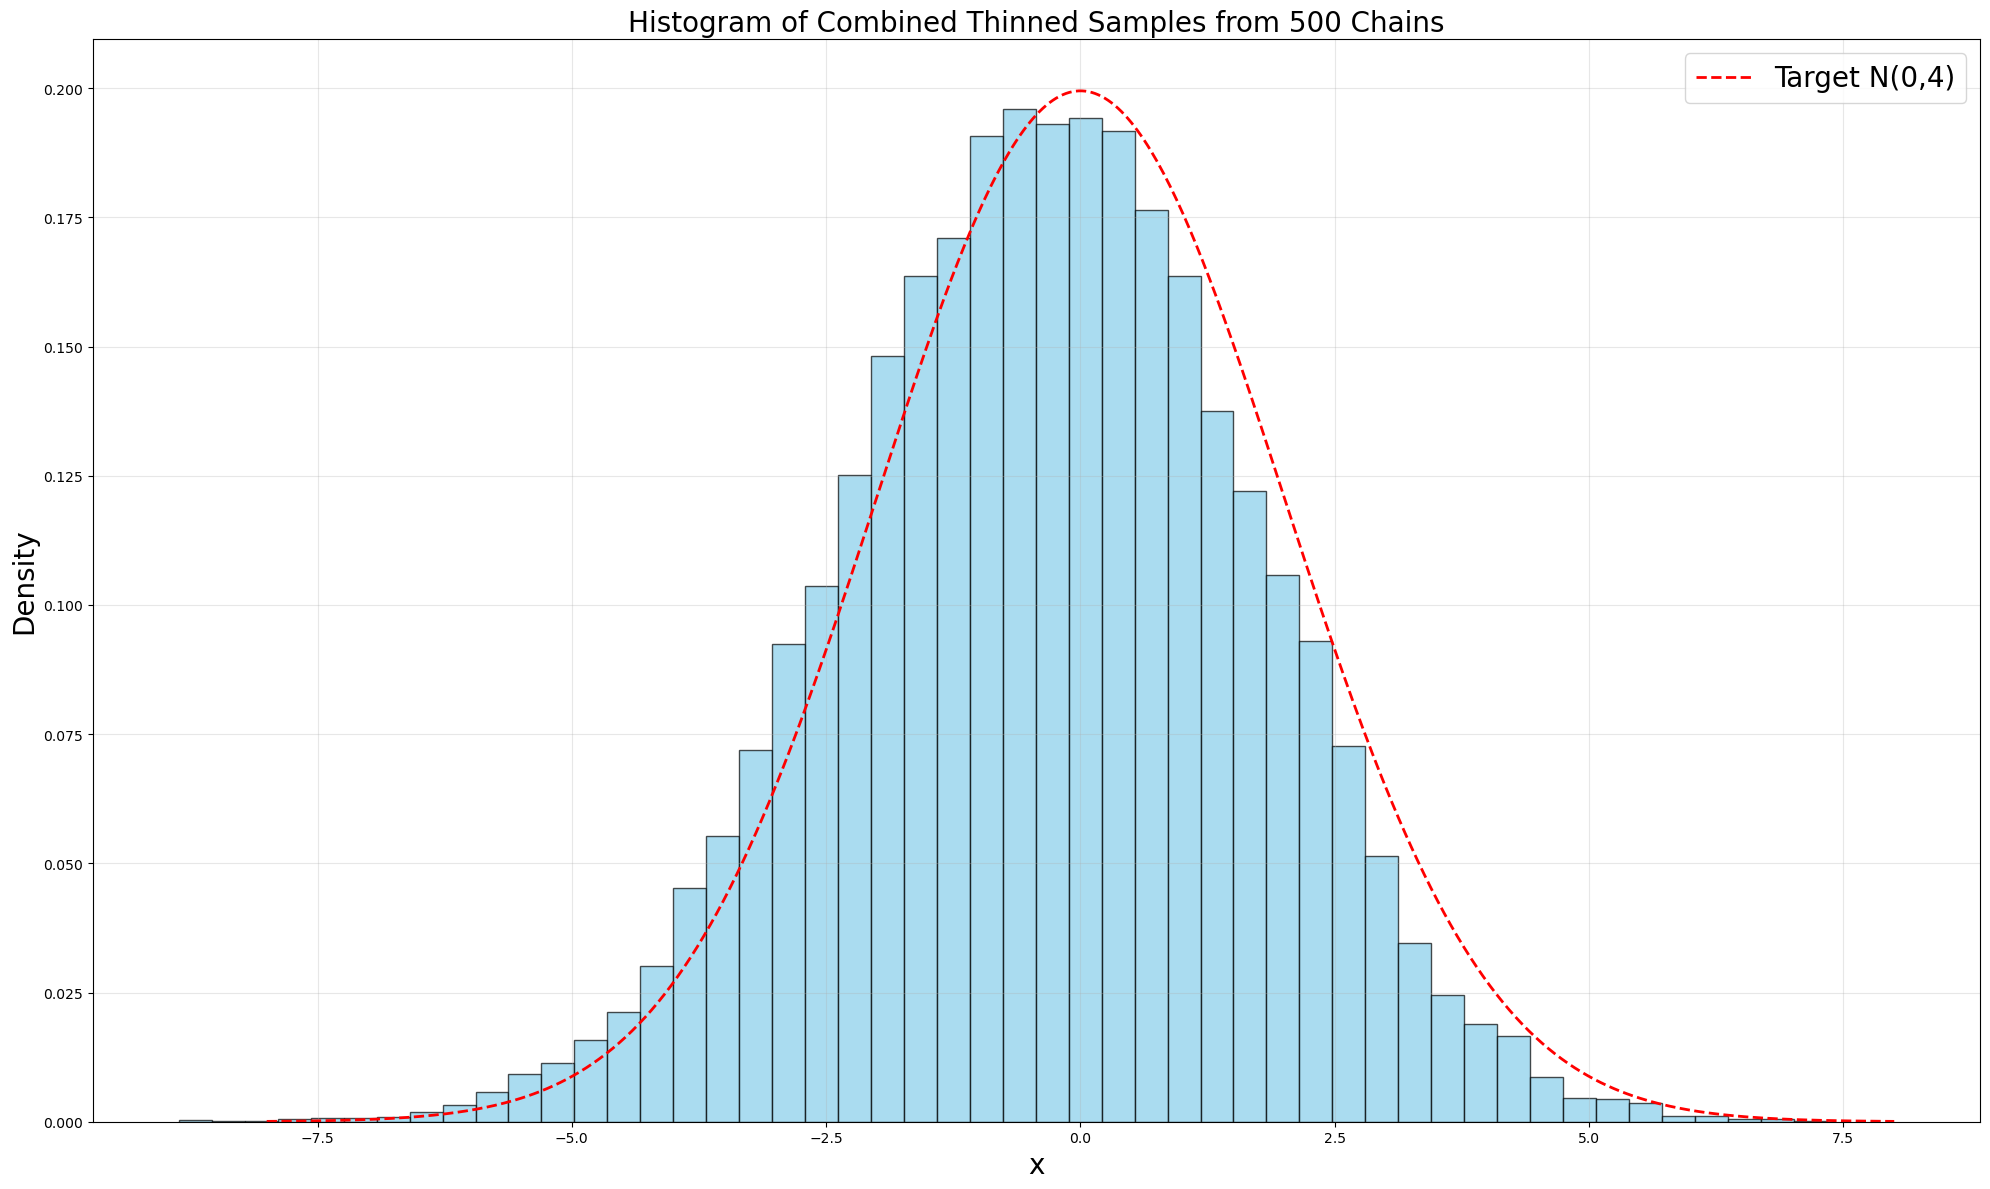

In [7]:
# multiple independent MCMC chains
num_chains = 500                 #number of chains to simulate
start_range = [-4, 8]            #range for random initialization (overdispersed)
all_samples = []                 #container for thinned samples

# simulate MCMC chains
for _ in range(num_chains):
    # draw a random initial state
    x0 = np.random.uniform(*start_range)
    # run a single Metropolis–Hastings chain
    chain = metropolis_hastings(target=target,T=T, x0=0, proposal_fn=proposal_fn, proposal_density_fn=proposal_density_fn, step_size=1.0)
    # discard burn-in
    post_burnin = chain[burn_in:]
    # apply thinning: retain every 'thinning' sample
    thinned = post_burnin[::thinning]
    # store thinned samples from this chain
    all_samples.extend(thinned)

# convert list to NumPy array for plotting/analysis
all_samples = np.array(all_samples)

# plot
plt.figure(figsize=(20, 12))
plt.hist(all_samples, bins=50, density=True, alpha=0.7, color='skyblue', edgecolor='black')
x_vals = np.linspace(-8, 8, 500)
plt.plot(x_vals, norm.pdf(x_vals, 0, 2), 'r--', lw=2, label="Target N(0,4)")
plt.title("Histogram of Combined Thinned Samples from 500 Chains", fontsize=20)
plt.xlabel("x", fontsize=20)
plt.ylabel("Density", fontsize=20)
plt.legend(fontsize=20)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()